## Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

## Preprocessing and Cleaning

In [ ]:
def clean_and_preprocess(df):
    # 1. Remove duplicate rows
    df = df.drop_duplicates()

    # 2. Create a 'Season_Start_Year' column (if 'Season' column exists)
    if 'Season' in df.columns and df['Season'].dtype == 'object':
        df['Season_Start_Year'] = df['Season'].str[:4].astype(int)

    # if 'Player' in df.columns and 'Tm' in df.columns:
    #   # Merge on 'Player', 'Tm', and 'Season' to account for multiple seasons on the same team
    #   df = pd.merge(df, df3[['Player', 'Tm', 'Season']], on=['Player', 'Tm'], how='left')

    # 3. Convert 'MVP' to boolean (if it exists and is not already boolean)
    if 'MVP' in df.columns and df['MVP'].dtype != 'bool':
        # Assuming 'MVP' column contains values like 'Yes'/'No' or 1/0
        df['MVP'] = df['MVP'].astype(bool)

    # 4. Calculate 'Points_Per_Minute' if 'PTS' and 'MP' columns exist
    if 'PTS' in df.columns and 'MP' in df.columns:
        # To avoid division by zero, replace zero minutes with NaN, then fill with 0
        df['Points_Per_Minute'] = df.apply(
            lambda row: row['PTS'] / row['MP'] if row['MP'] > 0 else 0, axis=1
        )

    # 5. Handle missing values for numeric columns by filling with 0
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df[numeric_columns] = df[numeric_columns].fillna(0)

    # Additional Cleaning (if necessary)
    # Example: Removing players with zero minutes played
    if 'MP' in df.columns:
        df = df[df['MP'] > 0]

    return df

## Combine the test and train dataset for final run

In [ ]:
# Load and combine the datasets
def load_and_combine_data():
    train_data = cleaned_train
    test_data = cleaned_test
    season_team_data = cleaned_team_stats

    # Combine train and test data
    combined_data = pd.concat([train_data, test_data], axis=0, ignore_index=True)

    # Merge with season_team_data
    season_team_data = season_team_data.drop_duplicates(subset=['Rk', 'Player', 'Tm'])
    combined_data = combined_data.merge(
        season_team_data[['Rk', 'Player', 'Season', 'Tm']],
        on=['Rk', 'Player', 'Tm'],
        how='left'
    )

    return combined_data

## Feature Engineering

In [ ]:
# Feature selection and engineering
def feature_engineering(data):
    features = ['PTS', 'AST', 'TRB', 'STL', 'BLK', 'Points_Per_Minute', 'FG%', 'eFG%', 'MP', 'TOV', 'FTA', 'Pos']

    # Handle categorical variable 'Position'
    data_processed = data[features].copy()
    data_processed = pd.get_dummies(data_processed, columns=['Pos'])

    # Normalize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data_processed)
    scaled_df = pd.DataFrame(scaled_features, columns=data_processed.columns)

    return scaled_df

## PCA

In [ ]:
# Perform PCA
def perform_pca(data, n_components=3):
    pca = PCA(n_components=n_components)
    pca_components = pca.fit_transform(data)
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance ratio: {explained_variance}")
    return pca_components

## DBSCAN

In [ ]:
# DBSCAN clustering with parameter tuning
def dbscan_clustering(data, eps_range=np.arange(0.1, 1.1, 0.1), min_samples_range=range(3, 11)):
    best_score = -1
    best_params = {}
    best_labels = None

    for eps in eps_range:
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(data)

            if len(set(labels)) > 1:  # More than one cluster
                score = silhouette_score(data, labels)
                if score > best_score:
                    best_score = score
                    best_params = {'eps': eps, 'min_samples': min_samples}
                    best_labels = labels

    print(f"Best DBSCAN parameters: {best_params}")
    print(f"Best DBSCAN Silhouette Score: {best_score:.4f}")

    return best_labels

## Visualization

In [ ]:
# Visualize clusters
def visualize_clusters(pca_data, clusters, title):
    # 2D plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=clusters, palette='viridis')
    plt.title(f'{title} - 2D')
    plt.show()

    # 3D plot
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2],
                        c=clusters, cmap='viridis')
    plt.colorbar(scatter)
    plt.title(f'{title} - 3D')
    plt.show()

In [ ]:
def calculate_aggregate_score(data):
    """
    Calculate a weighted aggregate score for basketball players based on various statistics.

    Weights are assigned based on the relative importance of each stat:
    - Scoring metrics (PTS, FG%, eFG%) are weighted heavily
    - Playmaking (AST) and defense (STL, BLK) are weighted moderately
    - Efficiency metrics (TOV, Points_Per_Minute) are included as modifiers

    Returns normalized scores between 0-100
    """
    # Define weights for each statistic
    weights = {
        'PTS': 2.0,
        'AST': 1.2,
        'TRB': 1.0,
        'ORB': 0.9,
        'DRB': 0.5,
        'STL': 0.8,
        'BLK': 0.8,
        'TOV': -1.4,
        'FG%': 1.0,
        'eFG%': 2.0,
        '3P%': 1.8,
        'FT%': 1.0,
        'MP': 0.9,
        'FTA': 0.7
    }

    # Create copy of data to avoid modifications to original
    df = data.copy()

    # Normalize all features to 0-1 scale
    for column in weights.keys():
        min_val = df[column].min()
        max_val = df[column].max()
        df[column] = (df[column] - min_val) / (max_val - min_val)

    # Calculate base score
    aggregate_score = sum(df[stat] * weight for stat, weight in weights.items())

    # Apply efficiency modifiers
    # Penalize for turnovers (normalized and inverted)
    tov_penalty = (1 - (df['TOV'] - df['TOV'].min()) / (df['TOV'].max() - df['TOV'].min())) * 0.1

    # Minutes played modifier (give slight boost to players with more playing time)
    mp_modifier = (df['MP'] - df['MP'].min()) / (df['MP'].max() - df['MP'].min()) * 0.05

    # Combine everything
    final_score = aggregate_score + tov_penalty + mp_modifier

    # Normalize to 0-100 scale
    final_score = (final_score - final_score.min()) / (final_score.max() - final_score.min()) * 100

    return final_score

In [ ]:
# Create results DataFrame
def create_results_df(original_data, pca_data, clusters, cluster_type):
    results = pd.DataFrame({
        'Player': original_data['Player'],
        'Pos': original_data['Pos'],
        'PTS': original_data['PTS'],
        'AST': original_data['AST'],
        'TRB': original_data['TRB'],
        'STL': original_data['STL'],
        'BLK': original_data['BLK'],
        'Points_Per_Minute': original_data['Points_Per_Minute'],
        'FG%': original_data['FG%'],
        'eFG%': original_data['eFG%'],
        'MP': original_data['MP'],
        'TOV': original_data['TOV'],
        'FTA': original_data['FTA'],
        'Season': original_data['Season'],
        'Tm': original_data['Tm'],
        'Cluster': clusters,
        'PCA1': pca_data[:, 0],
        'PCA2': pca_data[:, 1],
        'PCA3': pca_data[:, 2]
    })

    # Rank players within clusters by points

    # Add aggregate score to results
    results['Aggregate_Score'] = calculate_aggregate_score(results)
    results['Rank'] = results.groupby('Cluster')['Aggregate_Score'].rank(ascending=False)

    return results

# MAIN

Explained variance ratio: [0.21982349 0.09398567 0.05922604]
Best DBSCAN parameters: {'eps': 1.0, 'min_samples': 7}
Best DBSCAN Silhouette Score: 0.5194


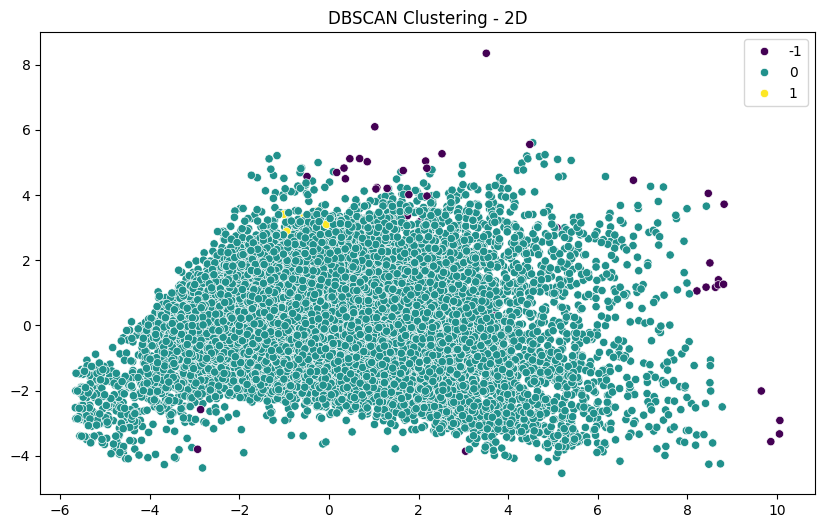

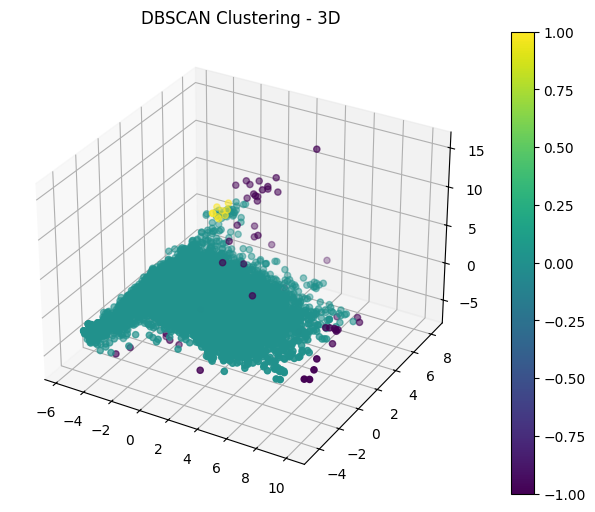

In [ ]:
# Apply the cleaning and preprocessing
file_path = '/content/nba_stats_train.csv'
file_path2 = '/content/nba_stats_test.csv'
file_path3 = '/content/NBA_Player_Stats_2.csv'
df = pd.read_csv(file_path)
df2 = pd.read_csv(file_path2)
df3 = pd.read_csv(file_path3)

cleaned_train = clean_and_preprocess(df)
cleaned_test = clean_and_preprocess(df2)
cleaned_team_stats = clean_and_preprocess(df3)

# Direct execution of the analysis
# Load and combine data
combined_data = load_and_combine_data()

# Process features
processed_data = feature_engineering(combined_data)

# Perform PCA
pca_components = perform_pca(processed_data)

# DBSCAN clustering
dbscan_clusters = dbscan_clustering(pca_components) #takes a couple of minutes to run
visualize_clusters(pca_components, dbscan_clusters, 'DBSCAN Clustering')
dbscan_results = create_results_df(combined_data, pca_components, dbscan_clusters, 'dbscan')

# Save results
dbscan_results.to_csv('combined_dbscan_results.csv', index=False)

# Top Clusters

In [ ]:
# Display top players in each cluster
for cluster_type, results in [('DBSCAN', dbscan_results)]:
    print(f"\nTop 10 Players by Aggregate_Score within each {cluster_type} Cluster:")
    for cluster_num in sorted(results['Cluster'].unique()):
        if cluster_num != -1:  # Exclude noise points for DBSCAN
            top_10 = results[results['Cluster'] == cluster_num].sort_values(by='Aggregate_Score').head(10)
            print(f"\nCluster {cluster_num}:")
            print(top_10[['Player', 'Pos', 'Season', 'PTS', 'AST', 'TRB', 'BLK', 'TOV', 'Tm', 'Aggregate_Score']])


Top 10 Players by Aggregate_Score within each DBSCAN Cluster:

Cluster 0:
                 Player Pos   Season  PTS  AST  TRB  BLK  TOV   Tm  \
6634               Nenê  PF  2003-04  0.0  0.0  0.0  0.0  2.0  DEN   
4919   Michael McDonald   C  1997-98  0.0  0.0  1.0  0.0  2.0  CHH   
6338      Darko Miličić   C  2012-13  0.0  0.0  1.0  0.0  2.0  BOS   
10439  Gheorghe Mureșan   C  1998-99  0.0  0.0  0.0  0.0  1.0  NJN   
14102    Larry Robinson  SG  2000-01  0.0  0.0  0.0  0.0  1.0  CLE   
2789      Courtney Sims   C  2008-09  0.0  0.0  0.0  0.0  1.0  PHO   
13843        Mark Baker  PG  1998-99  0.0  0.0  0.0  0.0  1.0  TOR   
5356          Coby Karl  SG  2009-10  0.0  0.0  0.7  0.0  1.3  CLE   
11458       Will Magnay   C  2020-21  0.0  0.0  0.0  0.0  1.0  NOP   
3462        Jeff Grayer  SG  1997-98  0.0  1.0  0.0  0.0  2.0  CHH   

       Aggregate_Score  
6634          4.889932  
4919          6.486138  
6338          6.681591  
10439         7.447976  
14102         7.447976  
2789

## Team Ranking

# Grouping per Team and Season

In [ ]:
# Group players by team and season, calculate average score per player, and rank them
def rank_team_rosters_by_average(clustered_data):
    # Ensure 'Player' column exists or count rows as a proxy
    if 'Player' not in clustered_data.columns:
        clustered_data['Player'] = 1  # Create a placeholder column to count players

    # Step 1: Group by team and season
    team_rosters = (
        clustered_data
        .groupby(['Season', 'Tm'])
        .agg({
            'Aggregate_Score': 'mean',  # Average team score per player
            'Player': 'size'           # Number of players in the roster
        })
        .rename(columns={'Aggregate_Score': 'Average_Score_Per_Player', 'Player': 'Player_Count'})
        .reset_index()
    )

    # Step 2: Rank teams within each season
    team_rosters['Rank'] = team_rosters.groupby('Season')['Average_Score_Per_Player'].rank(ascending=False, method='dense')

    # Sort for easier viewing
    team_rosters = team_rosters.sort_values(by=['Season', 'Rank'])

    # Display top results for each season
    print("==========================================================================\nTop Ranked Teams by Average Score per Player for Each Season:")
    for season in team_rosters['Season'].unique():
        top_teams = team_rosters[team_rosters['Season'] == season].head(10)
        print(f"\nSeason {season}:")
        print(top_teams[['Season', 'Tm', 'Average_Score_Per_Player', 'Player_Count', 'Rank']])

    return team_rosters

In [ ]:
# Display the top Aggregate_Score teams for each season
def display_top_teams(ranked_rosters, top_n=50):
    print("==========================================================================\nTop Ranked Teams for Each Season:")
    for season in ranked_rosters['Season'].unique():
        top_teams = ranked_rosters[ranked_rosters['Season'] == season].head(top_n)
        print(f"\nSeason {season}:")
        print(top_teams[['Season', 'Tm', 'Average_Score_Per_Player', 'Player_Count', 'Rank']])

In [ ]:
def generate_and_rank_all_rosters(clustered_data, team, year):
    """
    Generate and rank all possible 5-player rosters for a given team and year.

    Args:
    clustered_data (DataFrame): The dataset containing player and team data.
    team (str): The team abbreviation (e.g., 'LAL').
    year (int): The starting year of the season (e.g., 2015 for 2015-16).

    Returns:
    list: A list of dictionaries containing the top rosters and their scores.
    """
    # Convert the year into season format
    season = f"{year}-{str(year + 1)[-2:]}"

    # Step 1: Filter the data for the specified team and season
    team_data = clustered_data[(clustered_data['Tm'] == team) & (clustered_data['Season'] == season)]

    # Ensure there are at least 5 players to form a roster
    if len(team_data) < 5:
        print(f"Not enough players for Team {team} in Season {season} to form a 5-man roster.")
        print(f"Team {team} has only {len(team_data)} players in the specified season.")
        return None

    # Step 2: Generate all possible 5-player combinations
    player_combinations = list(combinations(team_data.index, 5))

    # Step 3: Compute the total score for each roster
    roster_scores = []
    for combo in player_combinations:
        roster = team_data.loc[list(combo)]
        total_score = roster['Aggregate_Score'].sum()
        roster_scores.append((combo, total_score))

    # Step 4: Rank the rosters by their total scores
    ranked_rosters = sorted(roster_scores, key=lambda x: x[1], reverse=False)

    # Step 5: Display the top 10 rosters
    print(f"==========================================================================\nAll Possible 5-Man Rosters for Team {team} in Season {season} (Top 10):")
    for i, (combo, score) in enumerate(ranked_rosters[:10]):
        roster = team_data.loc[list(combo)]
        print(f"\nRoster Aggregate_Score {i+1} (Total Score: {score:.2f}):")
        print(roster[['Player', 'Pos', 'Aggregate_Score', 'PTS', 'AST', 'TOV']])

    # Return the ranked rosters as a DataFrame for further use
    rosters_data = []
    for combo, score in ranked_rosters:
        roster = team_data.loc[list(combo)]
        roster_summary = {
            'Players': roster['Player'].tolist(),
            'Positions': roster['Pos'].tolist(),
            'Total_Score': score
        }
        rosters_data.append(roster_summary)

    return rosters_data

In [ ]:
def create_best_five_rosters(clustered_data):
    # Step 1: Sort data by Season, Team, and Aggregate_Score in descending order
    sorted_data = clustered_data.sort_values(by=['Season', 'Tm', 'Aggregate_Score'], ascending=[True, True, False])

    # Step 2: Group by Season and Team, then select the top 5 players for each group
    best_five_rosters = (
        sorted_data.groupby(['Season', 'Tm'])
        .head(5)  # Select the top 5 players per team per season
        .reset_index(drop=True)
    )

    # Step 4: Display top 5 players for a few teams
    print("==========================================================================\nTop 5-Man Rosters for Each Team in Each Season:")
    for season in best_five_rosters['Season'].unique():
        print(f"\nSeason {season}:")
        for team in best_five_rosters[best_five_rosters['Season'] == season]['Tm'].unique():
            print(f"Season {season}, Team {team}:")
            team_roster = best_five_rosters[(best_five_rosters['Season'] == season) & (best_five_rosters['Tm'] == team)]
            print(team_roster[['Player', 'Pos', 'Aggregate_Score', 'PTS', 'AST', 'TOV']])

    return best_five_rosters

In [ ]:
from itertools import combinations

def generate_and_rank_all_rosters(clustered_data, team, year):
    """
    Generate and rank all possible 5-player rosters for a given team and year.

    Args:
    clustered_data (DataFrame): The dataset containing player and team data.
    team (str): The team abbreviation (e.g., 'LAL').
    year (int): The starting year of the season (e.g., 2015 for 2015-16).

    Returns:
    list: A list of dictionaries containing the top rosters and their scores.
    """
    # Convert the year into season format
    season = f"{year}-{str(year + 1)[-2:]}"

    # Step 1: Filter the data for the specified team and season
    team_data = clustered_data[(clustered_data['Tm'] == team) & (clustered_data['Season'] == season)]

    # Ensure there are at least 5 players to form a roster
    if len(team_data) < 5:
        print(f"Not enough players for Team {team} in Season {season} to form a 5-man roster.")
        print(f"Team {team} has only {len(team_data)} players in the specified season.")
        return None

    # Step 2: Generate all possible 5-player combinations
    player_combinations = list(combinations(team_data.index, 5))

    # Step 3: Compute the total score for each roster
    roster_scores = []
    for combo in player_combinations:
        roster = team_data.loc[list(combo)]
        total_score = roster['Aggregate_Score'].sum()
        roster_scores.append((combo, total_score))

    # Step 4: Rank the rosters by their total scores
    ranked_rosters = sorted(roster_scores, key=lambda x: x[1], reverse=True)

    # Step 5: Display the top 10 rosters
    print(f"==========================================================================\nAll Possible 5-Man Rosters for Team {team} in Season {season} (Top 10):")
    for i, (combo, score) in enumerate(ranked_rosters[:10]):
        roster = team_data.loc[list(combo)]
        print(f"\nRoster Rank {i+1} (Total Score: {score:.2f}):")
        print(roster[['Player', 'Pos', 'Aggregate_Score', 'PTS', 'AST', 'TRB', 'BLK', 'STL', 'TOV']])

    # Return the ranked rosters as a DataFrame for further use
    rosters_data = []
    for combo, score in ranked_rosters:
        roster = team_data.loc[list(combo)]
        roster_summary = {
            'Players': roster['Player'].tolist(),
            'Positions': roster['Pos'].tolist(),
            'Total_Score': score
        }
        rosters_data.append(roster_summary)

    return rosters_data

# Ranked Team Average Per Year

In [ ]:
# Rank rosters for combined data based on average score per player
ranked_rosters_avg = rank_team_rosters_by_average(dbscan_results)

display_top_teams(ranked_rosters_avg)

Top Ranked Teams by Average Score per Player for Each Season:

Season 1997-98:
     Season   Tm  Average_Score_Per_Player  Player_Count  Rank
12  1997-98  LAL                 50.863693            13   1.0
27  1997-98  UTA                 48.793753            16   2.0
20  1997-98  PHO                 47.211953            15   3.0
28  1997-98  VAN                 47.007903            17   4.0
11  1997-98  LAC                 46.372873            17   5.0
9   1997-98  HOU                 45.571906            13   6.0
29  1997-98  WAS                 45.446340            20   7.0
6   1997-98  DEN                 45.070601            18   8.0
10  1997-98  IND                 44.937444            16   9.0
0   1997-98  ATL                 44.913080            17  10.0

Season 1998-99:
     Season   Tm  Average_Score_Per_Player  Player_Count  Rank
54  1998-99  SEA                 46.265681            16   1.0
38  1998-99  GSW                 46.238995            13   2.0
42  1998-99  LAL      

# Best Roster For each Team each Year

In [ ]:
create_best_five_rosters(dbscan_results)

Streaming output truncated to the last 5000 lines.
Season 1999-00, Team ATL:
               Player Pos  Aggregate_Score   PTS  AST  TOV
300  Dikembe Mutombo*   C        71.325600  11.5  1.3  2.1
301      Isaiah Rider  SG        60.845385  19.3  3.7  2.8
302       Jim Jackson  SF        58.322091  16.7  2.9  2.3
303    Alan Henderson  PF        58.185080  13.2  0.9  1.7
304       Jason Terry  PG        47.283426   8.1  4.3  1.9
Season 1999-00, Team BOS:
               Player Pos  Aggregate_Score   PTS  AST  TOV
305      Paul Pierce*  SF        72.966390  19.5  3.0  2.4
306    Antoine Walker  PF        71.624020  20.5  3.7  3.2
307    Adrian Griffin  SG        51.607948   6.7  2.5  1.3
308  Vitaly Potapenko   C        47.511601   9.2  1.0  1.8
309       Tony Battie   C        45.624769   6.6  0.8  0.8
Season 1999-00, Team CHH:
              Player Pos  Aggregate_Score   PTS  AST  TOV
310      Eddie Jones  SG        79.158611  20.1  4.2  2.2
311  Derrick Coleman  PF        66.284095  16.7

,Player,Pos,PTS,AST,TRB,STL,BLK,Points_Per_Minute,FG%,eFG%,...,TOV,FTA,Season,Tm,Cluster,PCA1,PCA2,PCA3,Aggregate_Score,Rank
0,Mookie Blaylock,PG,13.2,6.7,4.9,2.6,0.3,0.341969,0.392,0.440,...,2.5,1.9,1997-98,ATL,0,3.967422,-3.423345,-0.685598,71.764740,749.0
1,Dikembe Mutombo*,C,13.4,1.0,11.4,0.4,3.4,0.376404,0.537,0.537,...,2.0,5.5,1997-98,ATL,0,4.339975,4.766873,-3.309209,69.956859,913.0
2,Steve Smith,SG,20.1,4.0,4.2,1.0,0.4,0.514066,0.444,0.488,...,2.4,6.2,1997-98,ATL,0,4.095953,-1.336955,0.164959,67.228940,1207.0
3,Dikembe Mutombo*,C,10.8,1.1,12.2,0.3,2.9,0.295082,0.512,0.512,...,1.9,5.7,1997-98,ATL,0,3.801378,4.338782,-3.470444,65.796250,1402.0
4,Christian Laettner,PF,13.8,2.6,6.6,1.0,1.0,0.448052,0.485,0.489,...,2.5,4.8,1997-98,ATL,0,3.361969,0.791220,-1.197637,60.418582,2251.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3835,Kristaps Porziņģis,PF,22.1,2.9,8.8,0.7,1.5,0.783688,0.475,0.531,...,1.6,6.8,2021-22,WAS,0,4.841757,1.820905,-0.862484,77.726089,351.0
3836,Kyle Kuzma,PF,17.1,3.5,8.5,0.6,0.9,0.511976,0.452,0.520,...,2.6,3.3,2021-22,WAS,0,3.587838,0.862297,-1.068278,66.588848,1290.0
3837,Brad Wanamaker,PG,7.0,7.0,4.0,2.0,0.0,0.259259,0.400,0.400,...,0.0,3.0,2021-22,WAS,0,1.381357,-3.009002,-0.267991,64.081947,1633.0
3838,Montrezl Harrell,C,14.1,2.1,6.7,0.4,0.7,0.580247,0.645,0.650,...,1.1,4.5,2021-22,WAS,0,2.600618,2.815455,0.945172,62.689696,1872.0


# Roster Creation given a Year and a Team

In [ ]:
# Enter In Team and Year
team = 'CLE'
year = 2016
ranked_rosters = generate_and_rank_all_rosters(dbscan_results, team, year)

All Possible 5-Man Rosters for Team CLE in Season 2016-17 (Top 10):

Roster Rank 1 (Total Score: 361.59):
                 Player Pos  Aggregate_Score   PTS  AST   TRB  BLK  STL  TOV
834    Tristan Thompson   C        57.979773   8.1  1.0   9.2  1.1  0.5  0.8
6113       LeBron James  SF        89.632384  26.4  8.7   8.6  0.6  1.2  4.1
6970         Kevin Love  PF        71.071972  19.0  1.9  11.1  0.4  0.9  2.0
11579      Kyrie Irving  PG        76.977247  25.2  5.8   3.2  0.3  1.2  2.5
13381       Edy Tavares   C        65.924365   6.0  1.0  10.0  6.0  0.0  2.0

Roster Rank 2 (Total Score: 351.09):
             Player Pos  Aggregate_Score   PTS  AST   TRB  BLK  STL  TOV
5189     J.R. Smith  SG        47.480725   8.6  1.5   2.8  0.3  1.0  0.6
6113   LeBron James  SF        89.632384  26.4  8.7   8.6  0.6  1.2  4.1
6970     Kevin Love  PF        71.071972  19.0  1.9  11.1  0.4  0.9  2.0
11579  Kyrie Irving  PG        76.977247  25.2  5.8   3.2  0.3  1.2  2.5
13381   Edy Tavares   C      